Step 1 : Simulate Data

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [3]:
np.random.seed(42)

#Assume 10,000  visitors each
n_A, p_A = 10_000,0.10
n_B, p_B = 10_000,0.12

#Simulate numbers of purchases
success_A = np.random.binomial(n_A,p_A)
success_B = np.random.binomial(n_B,p_B)

Step 2 : Calculate Conversion Rate & 95% Confidence Intervals

In [4]:
def proportion_ci(success,n, alpha=0.05):
  p_hat = success/n
  z = stats.norm.ppf(1-alpha/2)
  se = np.sqrt(p_hat*(1-p_hat)/n)
  return p_hat, p_hat-z*se, p_hat+z*se

p_A_hat,ci_A_low,ci_A_high = proportion_ci(success_A,n_A)
p_B_hat,ci_B_low,ci_B_high = proportion_ci(success_B,n_B)

results = pd.DataFrame({
      'Variant' : ['A','B'],
      'Visitors' : [n_A,n_B],
      'Conversions' : [success_A,success_B],
      'CR (p)' : [p_A_hat,p_B_hat],
      'CI Lower (95%)' : [ci_A_low,ci_B_low],
      'CI Upper (95%)' : [ci_A_high,ci_B_high]
  })
print(results)

  Variant  Visitors  Conversions  CR (p)  CI Lower (95%)  CI Upper (95%)
0       A     10000          973  0.0973        0.091491        0.103109
1       B     10000         1134  0.1134        0.107185        0.119615


Step 3 : Plot Conversion Rates with Error Bars

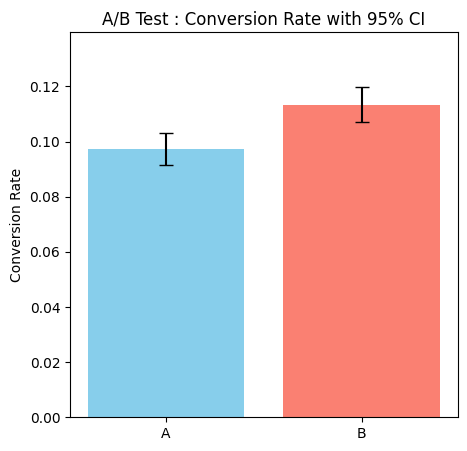

In [5]:
plt.figure(figsize=(5,5))
plt.bar(
    results['Variant'],
    results['CR (p)'],
    yerr=[results['CR (p)'] - results['CI Lower (95%)'],
          results['CI Upper (95%)'] - results['CR (p)']],
    capsize=5,
    color=['skyblue','salmon']
)
plt.ylabel('Conversion Rate')
plt.title('A/B Test : Conversion Rate with 95% CI')
plt.ylim(0, max(results['CI Upper (95%)'])+0.02)
plt.show()

Step 4 : Two-Proportion z-Test

In [6]:

count = np.array([success_B, success_A])
nobs = np.array([n_B, n_A])
z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.3f}")
if p_value < 0.05:
  print("->Reject HO: Variant B has a significantly higher conversion rate.")
else:
  print(" ->Fail to reject HO: No significant lift from B over A.")

Z-statistic: 3.708
P-value: 0.000
->Reject HO: Variant B has a significantly higher conversion rate.


In [11]:
import numpy as np, matplotlib.pyplot as plt, time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

true_p_A, true_p_B = 0.10, 0.12
batch_size = 100 #visitors per batch per variant
n_batches = 60 #simulate 60 time steps (e.g. minutes)

#Initialize counters

n_visits_A = n_visits_B = 0
n_succ_A=n_succ_B=0
# lists to store metrics for plotting
batches = []
p_values = []
lifts = []

Batch 60/60
 Variant A: 6000 visits, 592 buys->CR = 9.867%
 Variant B: 6000 visits, 690 buys->CR = 11.500%
 Observed lift: 1.633%
 z-stat= 2.90, p-value= 0.0019
 Significant lift detected (p<0.05).


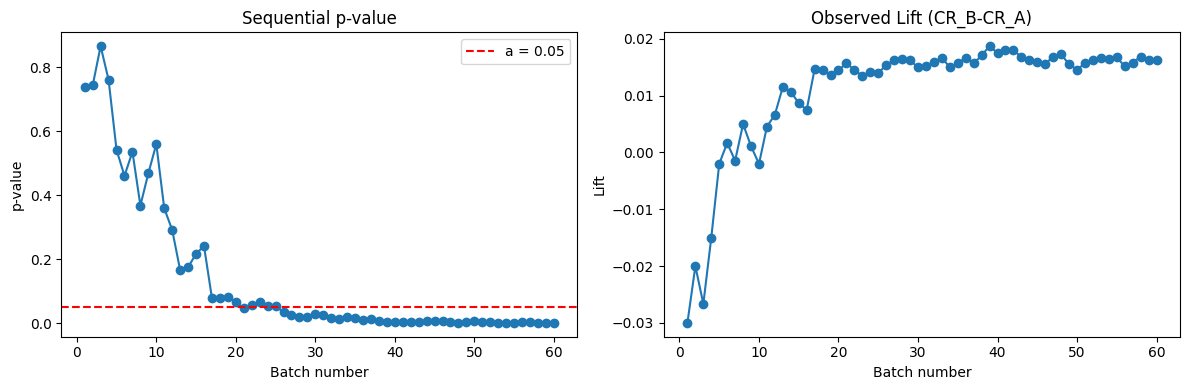

In [12]:
for batch in range(1,n_batches+1):
  #stimulate one batch of visitors
  new_A = np.random.binomial(batch_size, true_p_A)
  new_B = np.random.binomial(batch_size, true_p_B)
  #updates tools
  n_visits_A += batch_size
  n_visits_B += batch_size
  n_succ_A += new_A
  n_succ_B += new_B
  #compute current conversion rates
  cr_A = n_succ_A / n_visits_A
  cr_B = n_succ_B / n_visits_B
  lift = cr_B - cr_A
  #two proportion z-test (one-sided:B>A)
  count = np.array([n_succ_B, n_succ_A])
  nobs = np.array([n_visits_B, n_visits_A])
  z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')
  #record for plotting
  batches.append(batch)
  p_values.append(p_val)
  lifts.append(lift)

  #clear previous output and print current stats
  clear_output(wait=True)
  print(f"Batch {batch}/{n_batches}")
  print(f" Variant A: {n_visits_A} visits, {n_succ_A} buys->CR = {cr_A:.3%}")
  print(f" Variant B: {n_visits_B} visits, {n_succ_B} buys->CR = {cr_B:.3%}")
  print(f" Observed lift: {lift:.3%}")
  print(f" z-stat= {z_stat:.2f}, p-value= {p_val:.4f}")
  if p_val < 0.05:
    print(" Significant lift detected (p<0.05).")
  else:
    print(" No significant lift yet.")
  #plot p-value and lift over batches
  fig,axes = plt.subplots(1,2,figsize=(12,4))
  axes[0].plot(batches, p_values, '-o')
  axes[0].axhline(0.05, color='red', linestyle='--', label='a = 0.05')
  axes[0].set_title('Sequential p-value')
  axes[0].set_xlabel('Batch number')
  axes[0].set_ylabel('p-value')
  axes[0].legend()

  axes[1].plot(batches, lifts, '-o')
  axes[1].set_title('Observed Lift (CR_B-CR_A)')
  axes[1].set_xlabel('Batch number')
  axes[1].set_ylabel('Lift')

  plt.tight_layout()
  plt.show()
  # pause briefly to stimulate real time
  time.sleep(0.9)